In [1]:
import datetime # для работы со времнем
import gc # сборщик мусора

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor

%matplotlib inline

In [2]:
DATASET_PATH = '/kaggle/input/realestatepriceprediction/train.csv'
TEST_DATASET_PATH = '/kaggle/input/realestatepriceprediction/test.csv'

df = pd.read_csv(DATASET_PATH)

X = df.copy()
y = df[['Price']]

X_final = pd.read_csv(TEST_DATASET_PATH)

# сразу создам
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

# Удалим ненужные файлы
del df
gc.collect()  

Строк в трейне: 10000
Строк в тесте 5000


4

In [3]:
class Data:
    
    def __init__(self):
        """Константы для обработки выбросов на основе анализа данных"""
        self.Square_min = 15
        self.Square_max = 300
        
        self.LifeSquare_min = 10
        self.LifeSquare_max = 280
        
        self.Rooms_min = 1
        self.Rooms_max = 5
        
        self.HouseFloor_min = 1
        self.HouseFloor_max = 50
        
        self.KitchenSquare_min = 3
        self.KitchenSquare_max = 30
        
        self.current_year = datetime.datetime.now().year
        
        self.medians = None
        self.DistrictId_value_counts = None
        self.SquareMeterPrice_by_DistrictId = None
        self.Healthcare_1_by_DistrictId = None
        
        
    def fit(self, df):
        
        # медианные значения
        self.medians = df[['LifeSquare', 'HouseFloor']].median()
        
        # подсчет популярных районов
        self.DistrictId_value_counts = dict(df['DistrictId'].value_counts())
        
        # подсчет средней цены за м2 по району
        df_temp = df.loc[((df['Square'] > self.Square_min) & (df['Square'] < self.Square_max))]
        df_temp["SquareMeterPrice"] = df_temp["Price"] / df_temp["Square"]
        self.SquareMeterPrice_by_DistrictId = df_temp.groupby('DistrictId', as_index=False)\
            .agg({'SquareMeterPrice': 'mean'})\
            .rename(columns={'SquareMeterPrice': 'AverageSquareMeterPrice'})
        
        # подсчет среднего значения признака Healthcare_1 по району
        self.Healthcare_1_by_DistrictId = df.groupby('DistrictId', as_index=False)\
            .agg({'Healthcare_1': 'mean'})\
            .rename(columns={'Healthcare_1': 'AverageHealthcare_1'})
        
        del df_temp
        
    def transform(self, df):
        
        # Обработка пропусков
        df[['LifeSquare', 'HouseFloor']] = df[['LifeSquare', 'HouseFloor']].fillna(self.medians)
        
        # Обработка выбросов
        
        # площадь
        df.loc[(df['Square'] > self.Square_max), 'Square'] = self.Square_max
        df.loc[(df['Square'] < self.Square_min), 'Square'] = self.Square_min
        
        # жилая площадь
        df.loc[(df['LifeSquare'] < self.LifeSquare_min), 'LifeSquare'] = self.LifeSquare_min
        df.loc[(df['LifeSquare'] > self.LifeSquare_max), 'LifeSquare'] = self.LifeSquare_max
        
        # площадь кухни
        df.loc[(df['KitchenSquare'] < self.KitchenSquare_min), 'KitchenSquare'] = self.KitchenSquare_min
        df.loc[(df['KitchenSquare'] > self.KitchenSquare_max), 'KitchenSquare'] = self.KitchenSquare_max
        
        # год постройки дома
        df.loc[(df['HouseYear'] > self.current_year), 'HouseYear'] = self.current_year
        
        # количество комнат
        df.loc[(df['Rooms'] > self.Rooms_max), 'Rooms'] = self.Rooms_max
        df.loc[(df['Rooms'] < self.Rooms_min), 'Rooms'] = self.Rooms_min
        
        # количество этажей
        df.loc[(df['HouseFloor'] < self.HouseFloor_min), 'HouseFloor'] = self.HouseFloor_min
        df.loc[(df['HouseFloor'] > self.HouseFloor_max), 'HouseFloor'] = self.HouseFloor_max
        
        # если этаж больше этажности дома, то присваиваем случайный этаж от self.HouseFloor_min до максимального этажа в доме
        floor_outliers = df.loc[df['Floor'] > df['HouseFloor']].index
        df.loc[floor_outliers, 'Floor'] = df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: self.HouseFloor_min if (self.HouseFloor_min == x) else np.random.randint(self.HouseFloor_min, x))
        
        # Обработка категорий
        df = pd.concat([df, pd.get_dummies(df['Ecology_2'], prefix='Ecology_2', dtype='int8')], axis=1)
        df = pd.concat([df, pd.get_dummies(df['Ecology_3'], prefix='Ecology_3', dtype='int8')], axis=1)
        df = pd.concat([df, pd.get_dummies(df['Shops_2'], prefix='Shops_2', dtype='int8')], axis=1)
        
        return df
    
    def features(self, df):
        
        # добавление признака популярности района
        df['DistrictId_counts'] = df['DistrictId'].map(self.DistrictId_value_counts)
        df['DistrictId_counts'].fillna(df['DistrictId_counts'].median(), inplace=True)
        
        # добавление признака средней стоимости м2 по району
        df = df.merge(self.SquareMeterPrice_by_DistrictId, on=["DistrictId"], how='left')
        df['AverageSquareMeterPrice'].fillna(df['AverageSquareMeterPrice'].median(), inplace=True)
        
        # добавление признака среднего значения Healthcare_1 по району
        df = df.merge(self.Healthcare_1_by_DistrictId, on=["DistrictId"], how='left')
        df['AverageHealthcare_1'].fillna(df['AverageHealthcare_1'].median(), inplace=True)
        
        return df
        

In [4]:
data_inst = Data()

# тренировочные данные
data_inst.fit(X)
X = data_inst.transform(X)
X = data_inst.features(X)

# валидационные данные
X_final = data_inst.transform(X_final)
X_final = data_inst.features(X_final)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
feature_names = ['AverageSquareMeterPrice', 'DistrictId_counts', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
                    'HouseFloor', 'HouseYear', 'Helthcare_2', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
                    'Shops_1', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B',
                    'AverageHealthcare_1']


X1 = X[feature_names]
X1_final = X_final[feature_names]

In [6]:
model = LGBMRegressor(max_depth=-1,
#                       boosting_type='goss',
#                       class_weight = 'balanced',
                      objective =  'regression',
                      importance_type = 'gain',
                      subsample_for_bin = 1000,
                             min_child_samples=10,
                             num_leaves = 15, 
                             n_estimators=500,
                             random_state=42)

cv_score = cross_val_score(model, X1, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=6, shuffle=True, random_state=42))

model.fit(X1, y)
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.757 +- 0.025


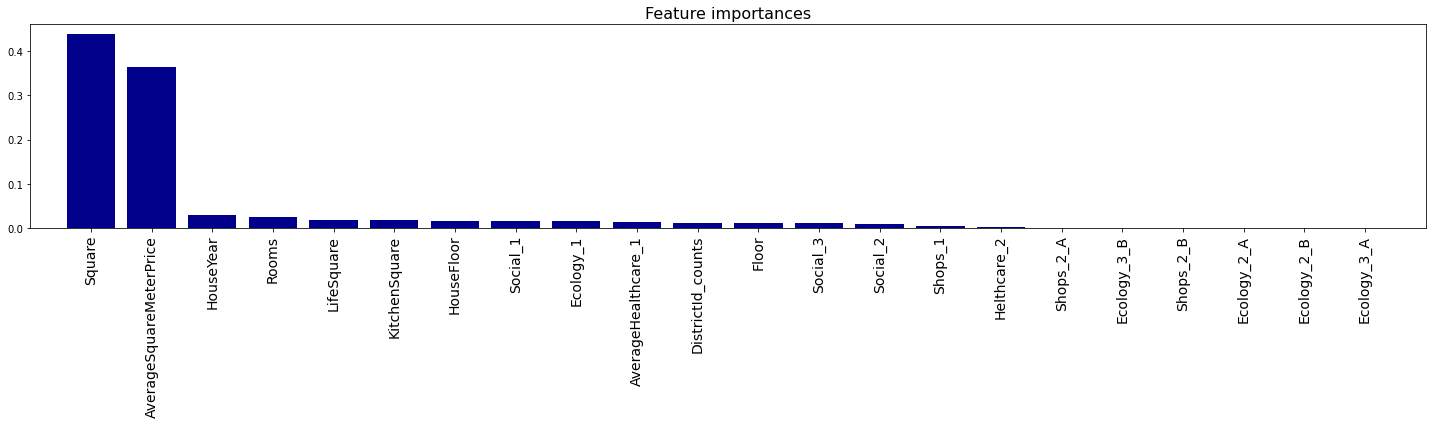

In [7]:
def plot_feature_importances(importances, X1):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X1.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X1.shape[1]), X1.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X1.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X1=X1)

In [8]:
y_pred_final = model.predict(X1_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions.csv', index=False)

preds_final.head()

,Id,Price
0,725,156630.761295
1,15856,218613.310378
2,5480,340399.965179
3,15664,342959.105631
4,14275,143529.737066


In [9]:
from catboost import CatBoostRegressor

In [10]:
X2 = X[feature_names]
final_model = CatBoostRegressor(
    silent=True,
    learning_rate=0.1,
    iterations=1150,
    eval_metric='R2',
    depth=8
)

final_model.fit(X2, y)

cv_score = cross_val_score(
    final_model,
    X2,
    y,
    scoring='r2',
    cv=KFold(
            n_splits=5,
            shuffle=True,
            random_state=42
    )
)

mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.760 +- 0.022
